In [6]:
import os

import numpy as np

import pandas as pd

import keras
from keras.datasets import cifar10

import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread, imsave, imshow
from skimage.color import rgb2gray
from PIL import Image
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
%cd ../../../TCC/images_th_mean_4

d:\Documentos\Faculdade - UFPI\Weight Estimation\predict_ovinos\TCC\images_th_mean_4


In [3]:
def calcula_histograma(img):
    # convertendo a imagem em array numpy
    img = np.asarray(img)

    # achatando a matriz em array 1D
    flat = img.flatten()
    # coletando o histograma com a função numpy
    histogram, bin_edges = np.histogram(img, bins=256, range=(0, 256))
    return histogram

def media_histograma(histograma):
    soma = 0
    total = 0
    for i in range(len(histograma)):
        soma += histograma[i]*i
        total += histograma[i]
    return soma/total

def variancia_histograma(histograma,media):
    soma = 0
    total = 0
    for i in range(len(histograma)):
        soma += (i-media)**2*histograma[i]
        total += histograma[i]
    return soma/total

def skewness_histograma(histograma,media,variancia):
    desvio_padrao = variancia**0.5
    soma = 0
    total = 0
    if desvio_padrao != 0:
        for i in range(len(histograma)):
            soma += ((i-media)/desvio_padrao)**3*histograma[i]
            total += histograma[i]
        return soma/total
    else:
        return 0

def kurtosis_histograma(histograma,media,variancia):
    desvio_padrao = variancia**0.5
    soma = 0
    total = 0
    if desvio_padrao != 0:
        for i in range(len(histograma)):
            soma += ((i-media)/desvio_padrao)**4*histograma[i]
            total += histograma[i]
        return soma/total-3
    else:
        return 0

def energia_histograma(histograma):
    soma = 0
    for i in range(len(histograma)):
        soma += histograma[i]**2
    return soma

def entropia_histograma(histograma):
    soma = 0
    total = sum(histograma)
    for i in range(len(histograma)):
        p = histograma[i]/total
        if p > 0:
            soma += -p*math.log2(p)
    return soma

def descritor_histograma(imagem):
    histograma = calcula_histograma(imagem)
    media = round(media_histograma(histograma), 2)
    var = round(variancia_histograma(histograma, media), 2)
    sk = round(skewness_histograma(histograma, media, var), 2)
    kur = round(kurtosis_histograma(histograma,media,var), 2)
    ener = round(energia_histograma(histograma), 2)
    entr = round(entropia_histograma(histograma), 2)

    return [media,var,sk,kur,ener,entr]

In [ ]:
# result_images = list()
# path = "./"
# dirs = os.listdir(path)

# for item in dirs:
#     if os.path.isfile(path + item):
#         print(path + item)
#         img = imread(path + item)
#         result_images.append(descritor_histograma(img))

In [ ]:
# result_images[0]

[246.19, 2168.38, -5.1, 23.99, 1820760758098, 0.22]

In [ ]:
# np.savetxt("D:\Documentos\Faculdade - UFPI\Weight Estimation\predict_ovinos\TCC\Assets/dataset_descritor_normal_2.csv",
#            result_images, delimiter=";", fmt="%.2f")


In [ ]:
# import pandas as pd

# data_frame = pd.read_csv("D:\Documentos\Faculdade - UFPI\Weight Estimation\predict_ovinos\TCC\Assets/dataset_descritor_normal_2.csv", sep=';',
#                          names=['Media', 'Variancia', 'Skewness', 'Kurtosis', 'Energia', 'Entropia'])


In [ ]:
# data_frame.head()


,Media,Variancia,Skewness,Kurtosis,Energia,Entropia
0,246.19,2168.38,-5.10,23.99,1.820761e+12,0.22
1,247.44,1869.59,-5.55,28.78,1.838689e+12,0.19
2,239.89,3624.92,-3.73,11.94,1.083352e+11,0.32
3,250.25,1187.94,-7.12,48.74,1.879590e+12,0.13
4,250.81,1049.67,-7.61,55.94,1.887888e+12,0.12


In [ ]:
# data_frame.to_csv(
#     "D:\Documentos\Faculdade - UFPI\Weight Estimation\predict_ovinos\TCC\Assets/dataset_descritor_normal_2.csv", index=False, sep=';')


In [7]:
data_frame = pd.read_csv("D:\Documentos\Faculdade - UFPI\Weight Estimation\predict_ovinos\TCC\Assets/dataset_descritor_normal_2.csv", sep=';')


In [8]:
data_frame


,Media,Variancia,Skewness,Kurtosis,Energia,Entropia,Pesovivo
0,246.19,2168.38,-5.10,23.99,1.820761e+12,0.22,45.20
1,247.44,1869.59,-5.55,28.78,1.838689e+12,0.19,38.50
2,239.89,3624.92,-3.73,11.94,1.083352e+11,0.32,41.20
3,250.25,1187.94,-7.12,48.74,1.879590e+12,0.13,45.00
4,250.81,1049.67,-7.61,55.94,1.887888e+12,0.12,40.75
...,...,...,...,...,...,...,...
57,246.59,2073.30,-5.23,25.36,1.826465e+12,0.21,48.50
58,246.51,2092.34,-5.20,25.08,1.825323e+12,0.21,39.80
59,249.39,1399.51,-6.52,40.46,1.866895e+12,0.15,34.95
60,246.08,2194.61,-5.06,23.62,1.818957e+12,0.22,42.20


### Modelos de predição

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score



def pred_randomForestRegressor(X, y):
    """
    X é uma matriz onde cada linha corresponde aos atributos calculados com o descritor
    y são os rótulos da classe de cada imagem. Exemplo [0,1,0,0,1,2,2,0,0,0,...,1]
    """
    # separar conjuntos de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

    # Fit the model
    model = RandomForestRegressor()
    model = model.fit(X_train, y_train)
    
    importance = model.feature_importances_
    
    plt.bar([x for x in range(len(importance))], importance)

    plt.xticks([x for x in range(len(importance))],
            X.columns.values.tolist(), rotation=30)
    plt.show()
    
    y_test_predict = model.predict(X_test)
    
    plt.scatter(y_test-y_test_predict, y_test_predict)

    plt.show()
    
    # model evaluation for training set
    y_train_predict = model.predict(X_train)

    rmse_train = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
    r2_train = r2_score(y_train, y_train_predict)

    print(f"RMSE for training is {rmse_train}")
    print(f"R2 score for training is {r2_train}")
    
    # model evaluation for training set
    y_test_predict = model.predict(X_test)

    rmse_test = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
    r2_test = r2_score(y_test, y_test_predict)

    print(f"RMSE for testing is {rmse_test}")
    print(f"R2 score for testing is {r2_test}")
    
    from sklearn import metrics
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_predict))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_predict))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))
    
    return pd.DataFrame({'Actual': y_test, 'Predicted': y_test_predict})


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

def pred_RandomizedSearchCV(X, y):
        """
        X é uma matriz onde cada linha corresponde aos atributos calculados com o descritor
        y são os rótulos da classe de cada imagem. Exemplo [0,1,0,0,1,2,2,0,0,0,...,1]
        """

        # Number of trees in random forest
        n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
        # Number of features to consider at every split
        max_features = ['auto', 'sqrt']
        # Maximum number of levels in tree
        max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
        max_depth.append(None)
        # Minimum number of samples required to split a node
        min_samples_split = [2, 5, 10]
        # Minimum number of samples required at each leaf node
        min_samples_leaf = [1, 2, 4]
        # Method of selecting samples for training each tree
        bootstrap = [True, False]
        # Create the random grid
        random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}
        pprint(random_grid)
        
        # separar conjuntos de treino e teste
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

        # Use the random grid to search for best hyperparameters
        # First create the base model to tune
        rf = RandomForestRegressor()
        # Random search of parameters, using 3 fold cross validation,
        # search across 100 different combinations, and use all available cores
        model = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                                n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
        # Fit the random search model
        model.fit(X_train, y_train)

        y_test_predict = model.predict(X_test)

        plt.scatter(y_test-y_test_predict, y_test_predict)

        plt.show()

        # model evaluation for training set
        y_train_predict = model.predict(X_train)

        rmse_train = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
        r2_train = r2_score(y_train, y_train_predict)

        print(f"RMSE for training is {rmse_train}")
        print(f"R2 score for training is {r2_train}")

        # model evaluation for training set
        y_test_predict = model.predict(X_test)

        rmse_test = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
        r2_test = r2_score(y_test, y_test_predict)

        print(f"RMSE for testing is {rmse_test}")
        print(f"R2 score for testing is {r2_test}")

        from sklearn import metrics
        print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_predict))
        print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_predict))
        print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))

        return pd.DataFrame({'Actual': y_test, 'Predicted': y_test_predict})


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

def pred_linearRegression(X, y):
    """
    X é uma matriz onde cada linha corresponde aos atributos calculados com o descritor
    y são os rótulos da classe de cada imagem. Exemplo [0,1,0,0,1,2,2,0,0,0,...,1]
    """
    # separar conjuntos de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
    # criar instancia do classificador
    model = LinearRegression(fit_intercept=True, n_jobs=1000, copy_X=True, positive=True)

    model = model.fit(X_train, y_train)

    importance = model.coef_
    
    plt.bar([x for x in range(len(importance))], importance)

    plt.xticks([x for x in range(len(importance))], X.columns.values.tolist(), rotation=30)
    
    plt.show()
    
    y_test_predict = model.predict(X_test)
    
    plt.scatter(y_test-y_test_predict, y_test_predict)

    plt.show()
    
    # model evaluation for training set
    y_train_predict = model.predict(X_train)

    rmse_train = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
    r2_train = r2_score(y_train, y_train_predict)

    print(f"RMSE for training is {rmse_train}")
    print(f"R2 score for training is {r2_train}")
    
    # model evaluation for training set
    y_test_predict = model.predict(X_test)

    rmse_test = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
    r2_test = r2_score(y_test, y_test_predict)

    print(f"RMSE for testing is {rmse_test}")
    print(f"R2 score for testing is {r2_test}")
    
    print(model.intercept_)
    
    y_pred = model.predict(X_test)
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

    return pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})    

In [13]:
data_frame.Pesovivo


0     45.20
1     38.50
2     41.20
3     45.00
4     40.75
      ...  
57    48.50
58    39.80
59    34.95
60    42.20
61    39.75
Name: Pesovivo, Length: 62, dtype: float64

In [14]:
X = data_frame.drop('Pesovivo', axis=1)
y = data_frame['Pesovivo']


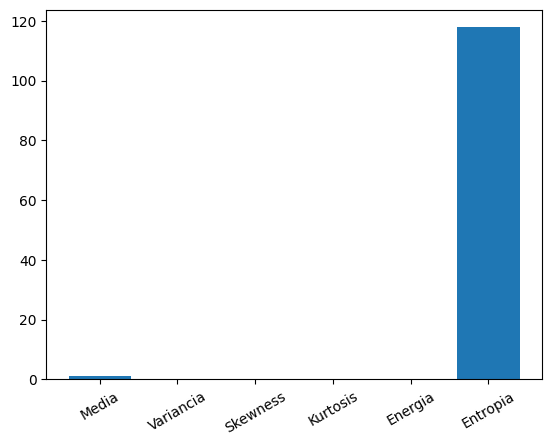

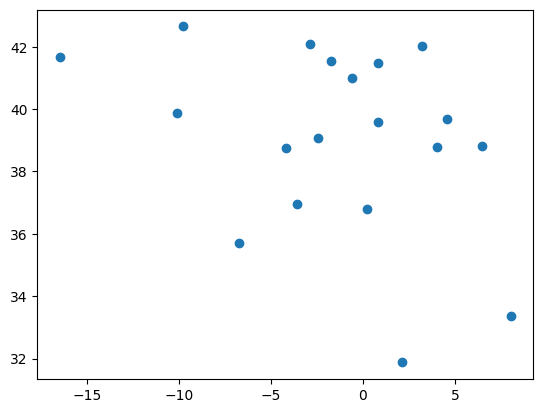

RMSE for training is 4.483447855247422
R2 score for training is 0.2314502398626337
RMSE for testing is 6.15913331906027
R2 score for testing is -0.19981384828156123
-277.50030476659344
Mean Absolute Error: 4.6690232008294394
Mean Squared Error: 37.93492324195838
Root Mean Squared Error: 6.15913331906027


,Actual,Predicted
38,33.40,36.966316
41,32.85,42.649002
13,36.60,39.063395
39,44.25,39.697540
31,40.40,41.003928
35,37.00,36.798086
14,29.80,39.874252
43,42.30,41.493104
58,39.80,41.539845
5,34.60,38.759239


In [15]:
pred_linearRegression(X,y)

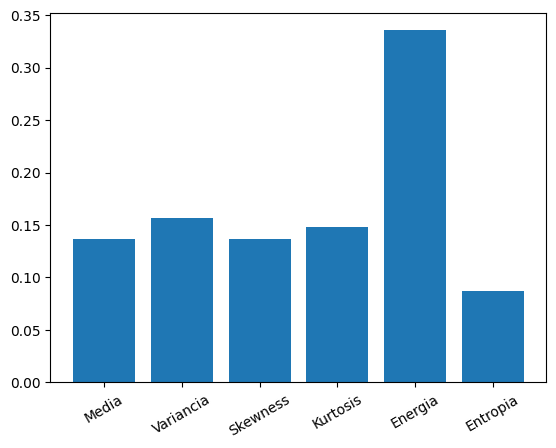

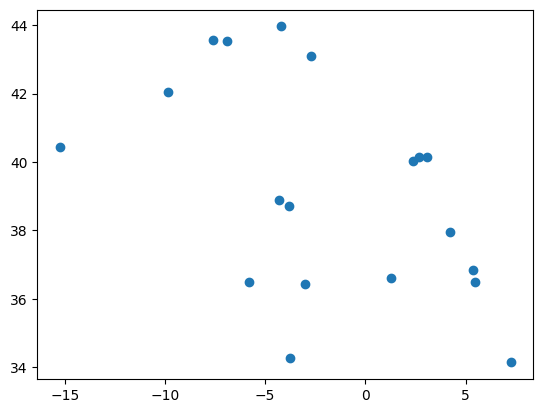

RMSE for training is 2.336671881663782
R2 score for training is 0.8073443925601032
RMSE for testing is 6.0815862434764645
R2 score for testing is -0.4455066926966498
Mean Absolute Error: 5.206263157894741
Mean Squared Error: 36.98569123684218
Root Mean Squared Error: 6.0815862434764645


,Actual,Predicted
11,36.00,43.5785
61,39.75,43.9605
15,36.60,43.5230
22,30.70,36.5015
40,42.40,40.0170
51,25.20,40.4410
36,42.80,40.1460
18,37.90,36.6205
7,40.40,43.1110
23,42.20,37.9630


In [16]:
pred_randomForestRegressor(X, y)


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


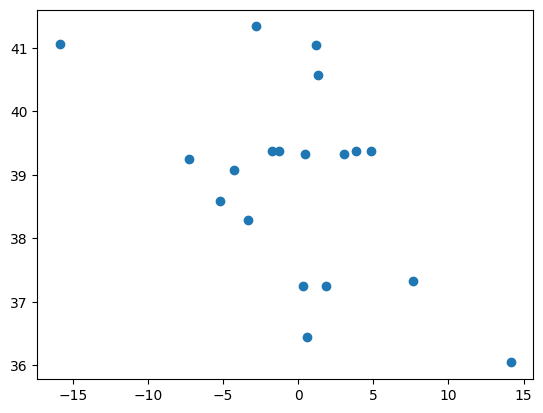

RMSE for training is 4.632351110472879
R2 score for training is 0.2409779242308664
RMSE for testing is 6.015726949281554
R2 score for testing is -0.24888150143567844
Mean Absolute Error: 4.268310112014426
Mean Squared Error: 36.18897072831235
Root Mean Squared Error: 6.015726949281554


,Actual,Predicted
3,45.00,37.327559
35,37.00,36.445720
42,34.80,39.077815
56,41.90,40.571552
51,25.20,41.065714
39,44.25,39.370640
1,38.50,41.335301
40,42.40,39.330741
38,33.40,38.589049
59,34.95,38.281227


In [17]:
pred_RandomizedSearchCV(X,y)

In [18]:
train_dataset = data_frame.sample(frac=0.8, random_state=0)
test_dataset = data_frame.drop(train_dataset.index)

train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Media,50.0,2.453672e+02,4.538424e+00,2.317600e+02,2.425500e+02,2.458750e+02,2.490075e+02,2.521900e+02
Variancia,50.0,2.343310e+03,1.058535e+03,7.077700e+02,1.491995e+03,2.243445e+03,3.019975e+03,5.385240e+03
Skewness,50.0,-5.357400e+00,1.595083e+00,-9.370000e+00,-6.292500e+00,-5.000000e+00,-4.185000e+00,-2.840000e+00
Kurtosis,50.0,2.920300e+01,1.933524e+01,6.070000e+00,1.554250e+01,2.298500e+01,3.758750e+01,8.587000e+01
Energia,50.0,1.152758e+12,8.609020e+11,1.017336e+11,1.106039e+11,1.804853e+12,1.861346e+12,1.908403e+12
Entropia,50.0,2.256000e-01,8.244132e-02,9.000000e-02,1.600000e-01,2.200000e-01,2.800000e-01,4.400000e-01
Pesovivo,50.0,3.791100e+01,5.273434e+00,2.520000e+01,3.465000e+01,3.840000e+01,4.177500e+01,5.020000e+01


In [19]:
train_labels = train_dataset.pop('Pesovivo')
test_labels = test_dataset.pop('Pesovivo')


In [20]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']


normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_train_data = normed_train_data.drop('Pesovivo', axis=1)
normed_test_data = normed_test_data.drop('Pesovivo', axis=1)


In [21]:
def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation='relu', input_shape=[
                   len(train_dataset.keys())]),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


In [22]:
model = build_model()


In [23]:
example_batch = normed_train_data[:10]
print(example_batch)
example_result = model.predict(example_batch)
example_result


     Energia  Entropia  Kurtosis     Media  Skewness  Variancia
30 -1.204783 -0.553121  0.159139  0.613164 -0.308824  -0.608908
32 -1.205636 -0.431822 -0.045668  0.434688 -0.095669  -0.423907
33 -1.212192  1.023758 -0.831280 -0.986510  0.919952   0.997973
48  0.723135  0.659863 -0.670434 -0.528201  0.681720   0.547256
51  0.769528 -0.067927 -0.332709  0.095364  0.236602  -0.078439
35 -1.211652  0.902460 -0.794042 -0.867526  0.863529   0.880820
11  0.809463 -0.553121  0.172586  0.624181 -0.327632  -0.619725
45 -1.214719  1.508952 -0.975576 -1.557193  1.158184   1.545947
2  -1.213173  1.145057 -0.892826 -1.206851  1.020261   1.210739
43 -1.220841  2.600638 -1.196416 -2.998222  1.578225   2.873716
1/1 [==============================] - 0s 152ms/step


array([[ 0.436356  ],
       [ 0.3749396 ],
       [-0.24771114],
       [-0.5289401 ],
       [-0.12053499],
       [-0.1826627 ],
       [ 0.16655846],
       [-0.49065232],
       [-0.3391116 ],
       [-1.0460424 ]], dtype=float32)

In [24]:
# Mostra o progresso do treinamento imprimindo um único ponto para cada epoch completada
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0:
      print('')
    print('.', end='')


EPOCHS = 10000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[PrintDot()])


C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
9995,10.166210,2.373971,10.166210,44.705021,5.683031,44.705021,9995
9996,9.798137,2.199592,9.798137,47.749191,6.184484,47.749191,9996
9997,9.753652,2.214423,9.753652,47.306366,6.008477,47.306366,9997
9998,9.431122,2.146193,9.431122,60.058857,6.657695,60.058857,9998
9999,10.227613,2.396749,10.227613,51.181915,6.127938,51.181915,9999


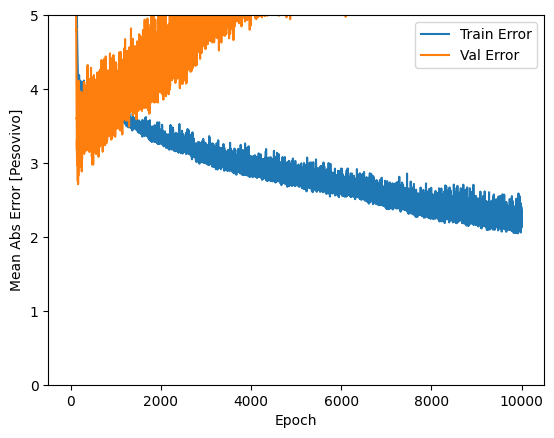

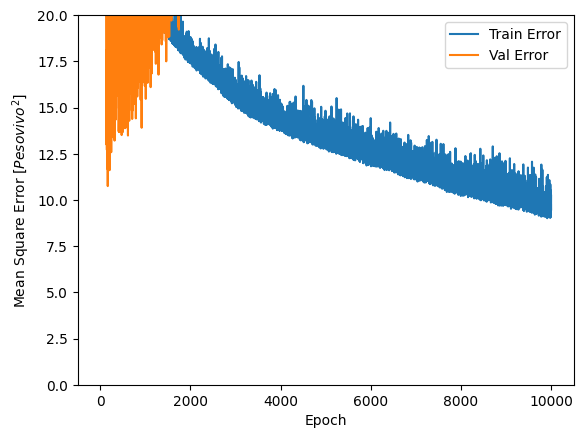

In [26]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Pesovivo]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label='Val Error')
  plt.ylim([0, 5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Pesovivo^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label='Val Error')
  plt.ylim([0, 20])
  plt.legend()
  plt.show()


plot_history(history)


C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
.............................

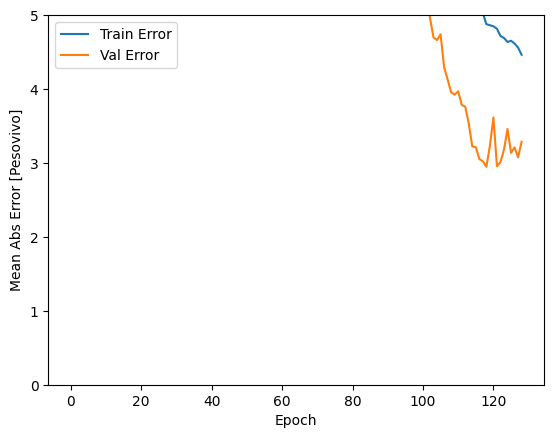

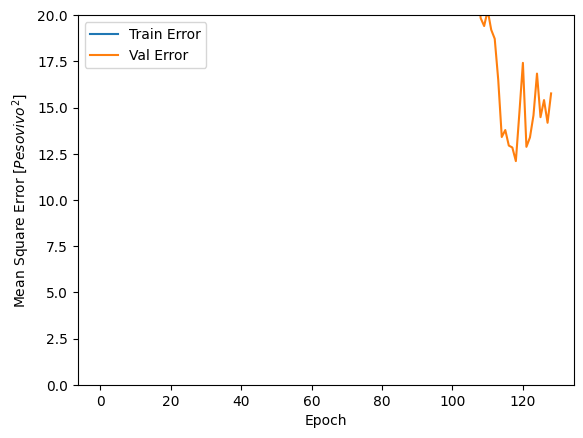

In [27]:
model = build_model()

# O parâmetro patience é o quantidade de epochs para checar as melhoras
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)


In [28]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} PESOVIVO".format(mae))


1/1 - 0s - loss: 32.6271 - mae: 4.6476 - mse: 32.6271 - 29ms/epoch - 29ms/step
Testing set Mean Abs Error:  4.65 PESOVIVO


1/1 [==============================] - 0s 67ms/step


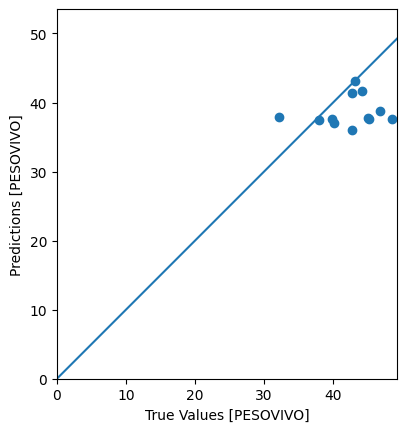

In [29]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [PESOVIVO]')
plt.ylabel('Predictions [PESOVIVO]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


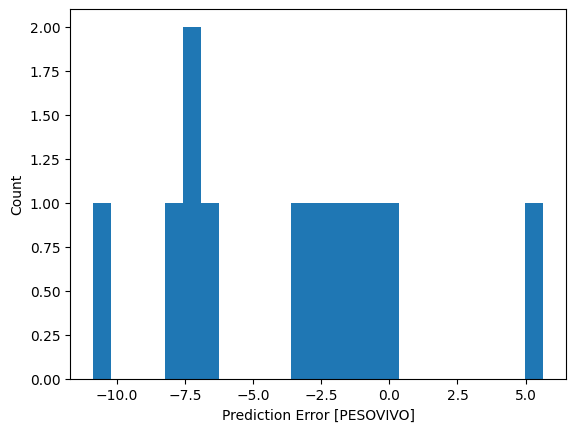

In [30]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [PESOVIVO]")
_ = plt.ylabel("Count")


In [31]:
df_aux = pd.DataFrame({'Actual': test_labels, 'Predicted': test_predictions})
df_aux


,Actual,Predicted
0,45.20,37.619591
3,45.00,37.802589
9,40.20,37.045784
19,39.80,37.669819
21,32.20,37.860184
36,42.80,41.311131
39,44.25,41.733379
44,43.20,43.183285
47,42.70,35.955059
50,46.75,38.839211
